<a href="https://colab.research.google.com/github/nahatx/30DayMapChal/blob/main/mapChallengeDay1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import time
# import warnings

## Fetch and prepare data

In [3]:
# Read an html table into a list of dataframes and select the dataframe containing Prime Ministers and their birth places
raw_minister_dataframe = pd.read_html("https://en.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom_by_birthplace")[1]

# filter the dataframe to the desired length of 31, which gives us the ministers since 1900 (27 total)
raw_minister_dataframe = raw_minister_dataframe[31:].copy().reset_index(drop=True)


# Get political party data
raw_party_dataframe = pd.read_html("https://simple.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom")[0]

## Clean the data

In [4]:
# Fix names to show first names, not initials
replace_names = {"H. H. Asquith": "Herbert Asquith"}
for key, value in replace_names.items():
    raw_minister_dataframe["Name"] = raw_minister_dataframe["Name"].str.replace(key, value)

# Create a 'Location' collumn that merges the 'Birthplace' and 'Country' columns
raw_minister_dataframe["Location"] = raw_minister_dataframe["Birthplace"] + ", " + raw_minister_dataframe["Country"]


# Fix names to match from both raw_dataframe's
raw_party_dataframe["Name"] = raw_party_dataframe["Name"].str.replace("Marquess of Salisbury", "Robert Gascoyne-Cecil").str.replace(
    "Andrew Bonar Law", "Bonar Law")

## Geocode the location

In [5]:
# Initialize Nominatim geocoder object, do not use default user agent for nominatim.openstreetmap.org API
nom_app = Nominatim(user_agent="map_project1")

latitude = [None] * len(raw_minister_dataframe)
longitude = [None] * len(raw_minister_dataframe)

In [6]:
# Some OpenStreetMap queries will not resolve,
# cache and manually fix each one using www.openstreetmap.org,
# then rerun this block to update them before moving on
needs_location_cleaning = []


# Manually correct and standardize place names for accurate geocoding here
# A fuzzer + a location list can probably be used to automate this on large datasets
replace_birth = {"Chorlton-on-Medlock, Lancashire,": "Chorlton-on-Medlock, Manchester",
                "Lossiemouth, Morayshire": "Lossiemouth, Moray",
                "Putney, Surrey" : "Putney, London",
                "Huddersfield, West Riding of Yorkshire": "Huddersfield, West Yorkshire",
                "Morley, West Riding of Yorkshire": "Morley, West Yorkshire",
                "St Helier, Surrey": "St Helier, London",
                "New Brunswick colony, modern day Canada" : "Canada"}
for key, value in replace_birth.items():
  raw_minister_dataframe["Location"] = raw_minister_dataframe["Location"].str.replace(key, value)


# Update geocoding for locations that have not been geocoded yet
for row in range(len(raw_minister_dataframe)):
  if not (latitude[row] and longitude[row]):
    location_data = nom_app.geocode(raw_minister_dataframe.loc[row]["Location"])
    if location_data:
      latitude[row] = location_data.raw["lat"]
      longitude[row] = location_data.raw["lon"]
    else:
      needs_location_cleaning.append(raw_minister_dataframe.loc[row]["Location"])
    # Must sleep to remain with rate limit (https://operations.osmfoundation.org/policies/nominatim/) AND get list of invalid searches
    time.sleep(1)


# Warn if there are geocoding failures, and output locations that need to be fixed manually
if len(needs_location_cleaning) > 0:
  print(f"Need to fix {len(needs_location_cleaning)} locations.", "Fix them and RERUN BLOCK!",
        "\nLocations:", *needs_location_cleaning, sep="\n")

## Merge datasets and save to a csv file

In [7]:
# Create a new dataframe containing the columns needed from the raw_minister_dataframe
minister_dataframe = pd.DataFrame()
minister_dataframe["Name"] = raw_minister_dataframe["Name"]
minister_dataframe["Latitude"] = latitude
minister_dataframe["Longitude"] = longitude

# Add political party for each Prime Minister
raw_party_dataframe = raw_party_dataframe.drop(columns="Time in office")
minister_dataframe = pd.merge(minister_dataframe, raw_party_dataframe, on="Name", how="inner")
minister_dataframe = minister_dataframe.drop_duplicates().reset_index(drop=True)


# Save the final, clean dataframe to a csv
minister_dataframe.to_csv("uk-prime-ministers-birthplaces.csv")

## Prepare geospacial data for mapping
Convert data into a GeoDataFrame

<Axes: >

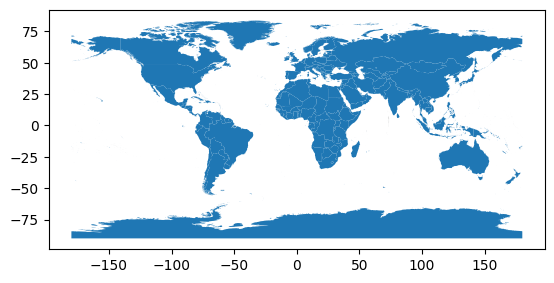

In [29]:
map_df = pd.read_csv("uk-prime-ministers-birthplaces.csv")

# #load shapefile
# regions_map = gpd.GeoDataFrame.from_file("uk_regions.geojson")
# print(regions_map)

#load world map
map_set = "/geojson/ne_10m_admin_0_countries.geojson"
world_map = gpd.GeoDataFrame.from_file(f"https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master{map_set}")


In [30]:
print(world_map)
# world_map.plot()

          featurecla  scalerank  LABELRANK                    SOVEREIGNT  \
0    Admin-0 country          0          2                     Indonesia   
1    Admin-0 country          0          3                      Malaysia   
2    Admin-0 country          0          2                         Chile   
3    Admin-0 country          0          3                       Bolivia   
4    Admin-0 country          0          2                          Peru   
..               ...        ...        ...                           ...   
253  Admin-0 country          0          4                         China   
254  Admin-0 country          6          5                     Australia   
255  Admin-0 country          6          8  Bajo Nuevo Bank (Petrel Is.)   
256  Admin-0 country          6          5               Serranilla Bank   
257  Admin-0 country          6          6              Scarborough Reef   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0      IDN         0      2  Sove

## Plot and annotate maps

## Save the final visualization